In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#call library

import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [5]:
scaler = MinMaxScaler()

def preprocessing(folder_name):
   # set file path
    folder_path = f'../../data/{folder_name}/'

    # load file name in folder
    file_names = os.listdir(folder_path)
    data_array = []
    # data_list = []

    for file in file_names:
        # set file path
        file_path = os.path.join(folder_path, file)
        
        # load csv file as dataframe
        df = pd.read_csv(file_path)

        #preprocessing column
        df['open-close'] = df['Open'] - df['Close'] #추가
        df['open-close'] = df['open-close'] + abs(min(df['open-close'])) #추가
        df['MA5'] = df['Close'].rolling(5).mean() #추가
        df = df.drop(['Unnamed: 0','Open'], axis=1)
        # df = df.rename(columns={'Adj Close':'Close'})
        df['Diff'] = df['High'] - df['Low']
        df = df.drop(['High','Low'], axis=1)

        #change 0 value to 0.000001
        #df = df.replace(0, 0.000001) -> np.log1p 메소드 사용

        #log transform
        df = np.log1p(df)

        #using minmaxscaler of each column in df
        df[['Close','Volume','Diff','open-close','MA5','Search']] = scaler.fit_transform(df[['Close','Volume','Diff','open-close','MA5','Search']])
        #df[['Close','Volume','Diff']] = scaler.fit_transform(df[['Close','Volume','Diff']])

        #insert list to array
        data_array.append(df)

    #list to numpy array and return
    return np.array(data_array)
        
        # save dataframe in variable without '.csv' extension
        # var_name = file.replace('.csv', '')
        # globals()[var_name] = df
        # data_list.append(var_name)

In [70]:
#call preprocessing function
xGrowths = preprocessing('growth_clean')
xValues = preprocessing('value_clean')
xOverlaps = preprocessing('overlap_clean')

In [71]:
def bootstrap(large, small):
    diff = len(large) - len(small)
    bootstrapped = small[np.random.choice(len(small), size=diff, replace=True)]
    return np.concatenate((small, bootstrapped), axis=0)

In [72]:
xGrowths = bootstrap(xValues, xGrowths)
xOverlaps = bootstrap(xValues, xOverlaps)

In [73]:
#generate y values
yGrowths = np.ones(len(xGrowths))
yValues = np.ones(len(xValues))
yOverlaps = np.ones(len(xOverlaps))

In [74]:
#concatenate growths and values
x = np.concatenate((xGrowths, xValues, xOverlaps), axis=0)
y = np.concatenate(
    (
        np.concatenate((np.ones(len(xGrowths)),np.zeros(len(xValues)),np.ones(len(xOverlaps))))[:, np.newaxis],
        np.concatenate((np.zeros(len(xGrowths)),np.ones(len(xValues)),np.ones(len(xOverlaps))))[:, np.newaxis]
    ), 
    axis=1
)

In [92]:
len(y)

3213

In [75]:
def splitData(x, y, train_ratio=0.8):
    # shuffle data
    permutation = np.random.permutation(len(x))
    x = x[permutation]
    y = y[permutation]

    # split data
    n_train_samples = int(train_ratio * len(x))
    x_train, x_test = x[:n_train_samples], x[n_train_samples:]
    y_train, y_test = y[:n_train_samples], y[n_train_samples:]

    return x_train, x_test, y_train, y_test

In [76]:
x_train, x_test, y_train, y_test = splitData(x, y)

In [77]:
# # to give more weight to minority class
# class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [78]:
# x_train = pad_sequences(x_train, dtype='float32')
# x_test = pad_sequences(x_test, dtype='float32')

# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)

In [79]:
#modify NaN to 0
x_train = np.nan_to_num(x_train, nan=0)
x_test = np.nan_to_num(x_test, nan=0)

# y_train = np.array([i[0] for i in y_train])
# y_test = np.array([i[0] for i in y_test])

In [80]:
x_train.shape #2570 data samples, 1248 days, 6 features

(2570, 1248, 6)

## Baseline model

In [81]:
from tensorflow.keras.layers import SimpleRNN

In [82]:
model = Sequential()
model.add(SimpleRNN(32, input_shape=(1248, 6)))
model.add(Dense(8))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [83]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 32)                1248      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 2)                 18        
                                                                 
Total params: 1,530
Trainable params: 1,530
Non-trainable params: 0
_________________________________________________________________


In [84]:
history = model.fit(x_train, y_train, epochs=100)

Epoch 1/100
81/81 [==============================] - 9s 95ms/step - loss: 0.6357 - acc: 0.5646
Epoch 2/100
81/81 [==============================] - 8s 99ms/step - loss: 0.6289 - acc: 0.5447
Epoch 3/100
81/81 [==============================] - 8s 95ms/step - loss: 0.6211 - acc: 0.6226
Epoch 4/100
81/81 [==============================] - 7s 91ms/step - loss: 0.6160 - acc: 0.5992
Epoch 5/100
81/81 [==============================] - 8s 94ms/step - loss: 0.6096 - acc: 0.5953
Epoch 6/100
81/81 [==============================] - 8s 101ms/step - loss: 0.6092 - acc: 0.6109
Epoch 7/100
81/81 [==============================] - 8s 99ms/step - loss: 0.6130 - acc: 0.5883
Epoch 8/100
81/81 [==============================] - 9s 109ms/step - loss: 0.6285 - acc: 0.5541
Epoch 9/100
81/81 [==============================] - 9s 116ms/step - loss: 0.6241 - acc: 0.5661
Epoch 10/100
81/81 [==============================] - 10s 125ms/step - loss: 0.6215 - acc: 0.5424
Epoch 11/100
81/81 [========================

In [43]:
model.save('rnn_all5_re.h5')

In [87]:
# import tensorflow as tf
# model = tf.keras.models.load_model('rnn_all5.h5')

In [90]:
count_10 = np.sum((y_test == [1, 0]).all(axis=1))
count_01 = np.sum((y_test == [0, 1]).all(axis=1))
count_11 = np.sum((y_test == [1, 1]).all(axis=1))

print(f"[1, 0]의 개수: {count_10}")
print(f"[0, 1]의 개수: {count_01}")
print(f"[1, 1]의 개수: {count_11}")

[1, 0]의 개수: 213
[0, 1]의 개수: 219
[1, 1]의 개수: 211


In [88]:
loss, accuracy = model.evaluate(x_test, y_test)
y_pred_prob = model.predict(x_test)

21/21 [==============================] - 1s 29ms/step


In [67]:
y_pred_label = y_pred_prob > 0.5

In [68]:
y_pred_label

array([[ True,  True],
       [ True, False],
       [ True,  True],
       ...,
       [ True,  True],
       [ True,  True],
       [ True,  True]])

In [69]:
y_pred_prob

array([[0.5583722 , 0.7061858 ],
       [0.88343173, 0.47012684],
       [0.81950146, 0.5209235 ],
       ...,
       [0.6674997 , 0.56173825],
       [0.59161144, 0.678264  ],
       [0.5189682 , 0.68528116]], dtype=float32)

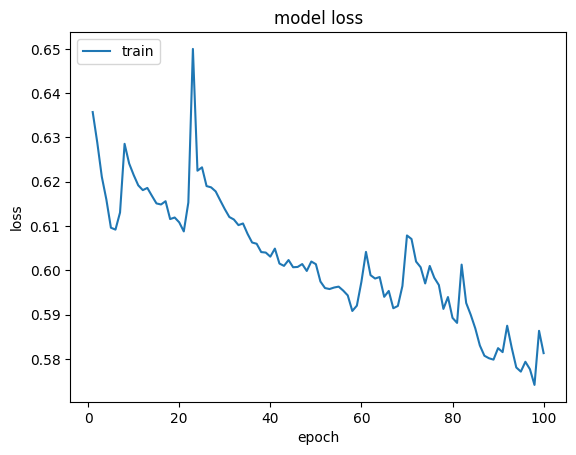

In [85]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

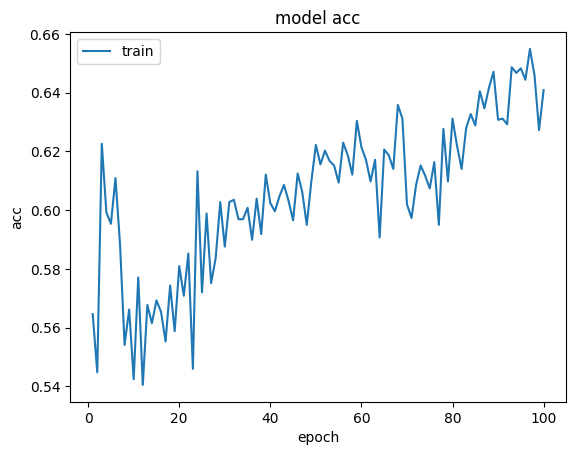

In [86]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()